**Part 2. AI Agent 활용 프로젝트**

- Chapter 02. 컨텍스트 품질을 보장하는 RAG

    - **📒[실습]** Clip 04. 부족한 내용은 웹에서 찾아오는 RAG 🗒️

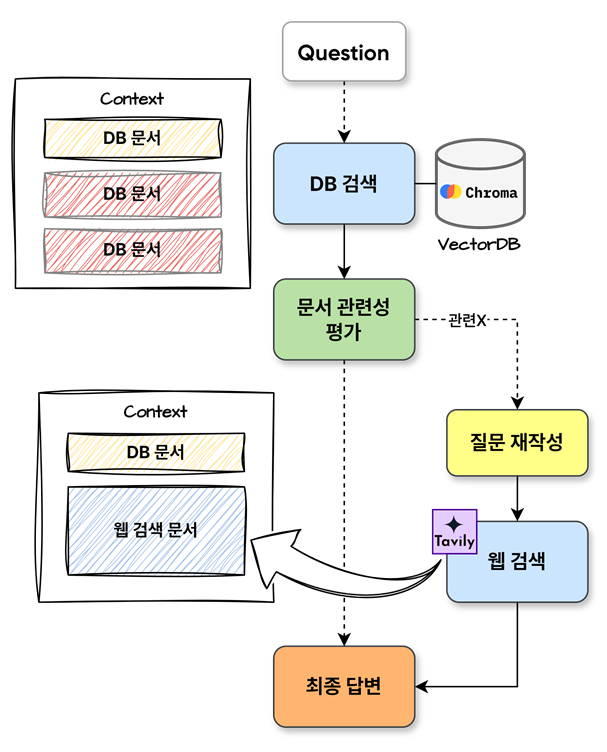

In [1]:
import getpass
import os

def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://langchain-ai.github.io/langgraph/concepts/why-langgraph/",
    "https://langchain-ai.github.io/langgraph/agents/tools/",
    "https://langchain-ai.github.io/langgraph/agents/overview/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
docs = text_splitter.split_documents(docs_list)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
docs

[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/concepts/why-langgraph/', 'title': 'Overview', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='Overview\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\nWe are growing and hiring for multiple roles for LangChain, LangGraph and LangSmith.  Join our team!\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            LangGraph\n          \n\n\n\n            \n              Overview\n            \n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            Initializing search\n          \n\n\n\n\n\n\n\n\n\n\n\n\n    GitHub\n  \n\n\n\n\n\n\n\n\n          \n  \n  \n    \n  \n  Guides'),
 Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/concepts/why-langgraph/', 'title': 'Overview', 'description': 'Build reliable, stateful AI systems, without giving up control'

In [4]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# 로더를 통해 불러왔던 문서 텍스트를 벡터 저장소에 적재
vectorstore = Chroma.from_documents(documents=docs, embedding=OpenAIEmbeddings(model="text-embedding-3-small"))

In [5]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

## 👉 Graph

In [6]:
from typing import List

from typing_extensions import TypedDict


class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        document_lack: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    document_lack: str # Yes or No
    documents: List[str]

### Step 1. Node

#### 1) Retrieve

In [7]:
def retrieve(state):
    """
    Retrieve documents
    """
    print("##### RETRIEVE #####")
    question = state["question"]
    documents = retriever.invoke(question) # list
    return {"documents": documents, "question": question}

#### 2) Retrieval Grader

In [8]:
from pydantic import BaseModel, Field

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [9]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    """

    print("##### CHECK DOCUMENT RELEVANCE TO QUESTION #####")
    question = state["question"]
    documents = state["documents"]

    system = """
        You are a grader assessing the relevance of a retrieved document to a user question. \n
        Grade the document as relevant ("yes") only if it contains the answer to the user question is clear within the given context. \n
        If the document is not related or does not provide sufficient information to resolve or help answer the question, grade it as not relevant ("no"). \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    """
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
        ]
    )

    retrieval_grader = grade_prompt | llm.with_structured_output(GradeDocuments)

    filtered_docs = []
    document_lack = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        print("score:", score)
        print("document:", d.page_content)
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            document_lack = "Yes"
            continue
        
    return {"documents": filtered_docs, "question": question, "document_lack": document_lack}

#### 3) Question Re-writer

In [10]:
def transform_query(state):
    """
    Transform the query to produce a better question.
    """

    print("##### TRANSFORM QUERY #####")
    question = state["question"]
    documents = state["documents"]

    system = """You a question re-writer that converts an input question to a better version that is optimized \n 
         for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )

    question_rewriter = re_write_prompt | llm

    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question.content}


#### 4) Web search

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [12]:
from langchain.schema import Document

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("##### WEB SEARCH #####")
    question = state["question"]
    documents = state["documents"]

    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    print("web_results", web_results)

    return {"documents": documents, "question": question}


#### 5) Generate

In [13]:
from langchain import hub

def generate(state: State):
    """
    Generate answer based on the retrieved document and the question.
    """
    print("##### GENERATE #####")
    question = state["question"]
    documents = state["documents"]
    print("question", question)
    print("context", documents)
    print(len(documents))
    prompt = hub.pull("rlm/rag-prompt")

    response = llm.invoke(
        prompt.format_messages(context=documents, question=question)
    )
    print("response", response)
    return {"documents": documents, "question": question, "generation": response.content}

In [14]:
from langgraph.graph import END, StateGraph, START

graph_builder = StateGraph(State)

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_node("generate", generate)
graph_builder.add_node("transform_query", transform_query)
graph_builder.add_node("web_search_node", web_search)

### Step 2. Edge

#### 1) 답변 생성 여부 결정

In [15]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    """

    print("##### ASSESS GRADED DOCUMENTS #####")
    document_lack = state["document_lack"]

    if document_lack == "Yes":
        if len(state["documents"]) == 0:
            print(
                "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
            )
            return "transform_query"
        else:
            print(
                "---DECISION: SOME DOCUMENTS ARE RELEVANT TO QUESTION, WEB SEARCH ---"
            )
            return "web_search_node" # "transform_query"
    else:
        print("---DECISION: GENERATE---")
        return "generate"

In [16]:
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "web_search_node": "web_search_node",
        "generate": "generate",
    },
)
graph_builder.add_edge("transform_query", "web_search_node")
graph_builder.add_edge("web_search_node", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

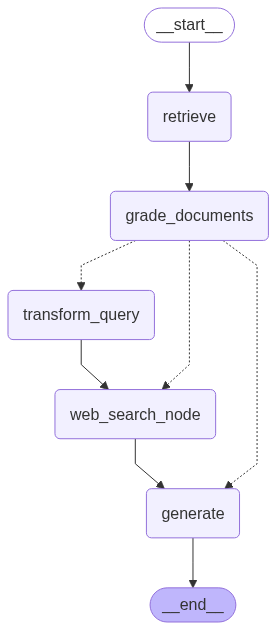

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


테스트!

In [17]:
inputs = {"question": "AI Agent를 사용하기 위한 Langgraph의 사용법은?"}
for output in graph.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
    print("\n---\n")

print(value["generation"])

##### RETRIEVE #####
Node 'retrieve':

---

##### CHECK DOCUMENT RELEVANCE TO QUESTION #####
score: binary_score='yes'
document: Agent development with LangGraph¶
LangGraph provides both low-level primitives and high-level prebuilt components for building agent-based applications. This section focuses on the prebuilt, reusable components designed to help you construct agentic systems quickly and reliably—without the need to implement orchestration, memory, or human feedback handling from scratch.
What is an agent?¶
An agent consists of three components: a large language model (LLM), a set of tools it can use, and a prompt that provides instructions.
The LLM operates in a loop. In each iteration, it selects a tool to invoke, provides input, receives the result (an observation), and uses that observation to inform the next action. The loop continues until a stopping condition is met — typically when the agent has gathered enough information to respond to the user.


Agent loop: the LLM s

c:\Users\pnylo\OneDrive\바탕 화면\Workspace\Langgraph_AIAgent_fastcampus\.conda\Lib\site-packages\langsmith\client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


response content='Langgraph를 사용하여 AI Agent를 사용하려면, 먼저 LLM(대형 언어 모델)을 정의하고 사용할 도구를 설정한 후, 에이전트를 정의합니다. Langgraph는 그래프 기반의 실행 프레임워크로, 복잡한 LLM 워크플로우를 설계하고 실행할 수 있도록 도와줍니다. 이를 통해 에이전트는 유저의 질문에 따라 적절한 도구를 선택하고 결과를 생성하여 최종 답변을 제공합니다.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 109, 'prompt_tokens': 3704, 'total_tokens': 3813, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BZ9imjNrzANyPkvxh9NTNssGvA7Ot', 'finish_reason': 'stop', 'logprobs': None} id='run-a91d9d15-4a72-4dbe-a6c2-1497dc8bb433-0' usage_metadata={'input_tokens': 3704, 'output_tokens': 109, 'total_tokens': 3813, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
Node 'generate':

--

In [18]:
inputs = {"question": "Langgraph를 사용하는 기업"}
for output in graph.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
    print("\n---\n")

print(value["generation"])

##### RETRIEVE #####
Node 'retrieve':

---

##### CHECK DOCUMENT RELEVANCE TO QUESTION #####
score: binary_score='no'
document: Reference

        



          
  
  
    
  
  Examples

        



          
  
  
    
  
  Resources

        

















    LangGraph
  






    GitHub
  








    Guides
    
  








            Guides
          





    Get started
    
  





            Get started
---GRADE: DOCUMENT NOT RELEVANT---
score: binary_score='no'
document: Reference

        



          
  
  
    
  
  Examples

        



          
  
  
    
  
  Resources

        

















    LangGraph
  






    GitHub
  








    Guides
    
  








            Guides
          





    Get started
    
  





            Get started
---GRADE: DOCUMENT NOT RELEVANT---
score: binary_score='no'
document: Reference

        



          
  
  
    
  
  Examples

        



          
  
  
    
  
  Resources

        

















    

c:\Users\pnylo\OneDrive\바탕 화면\Workspace\Langgraph_AIAgent_fastcampus\.conda\Lib\site-packages\langsmith\client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


response content='Companies currently using LangGraph technology include Replit, Uber, LinkedIn, GitLab, Klarna, Elastic, and Vodafone.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 1240, 'total_tokens': 1266, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BZ9lXwx3an3tbWE7CdktKeim7ziIP', 'finish_reason': 'stop', 'logprobs': None} id='run-9d65e3d9-57b5-41dc-9b17-9d279686801d-0' usage_metadata={'input_tokens': 1240, 'output_tokens': 26, 'total_tokens': 1266, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
Node 'generate':

---

Companies currently using LangGraph technology include Replit, Uber, LinkedIn, GitLab, Klar

In [19]:
value

{'documents': [Document(metadata={}, page_content='LangGraph — used by Replit, Uber, LinkedIn, GitLab and more — is a low-level orchestration framework for building controllable agents. While langchain provides integrations and composable components to streamline LLM application development, the LangGraph library enables agent orchestration — offering customizable architectures, long-term memory, and human-in-the-loop to reliably handle complex tasks. [...] While LangGraph is our open-source agent orchestration framework, enterprises that need scalable agent deployment can benefit from LangGraph Platform.\n\nLangGraph Platform can help engineering teams:\n\nAdditional resources¶\n\nAcknowledgements¶\n\nLangGraph is inspired by Pregel and Apache Beam. The public interface draws inspiration from NetworkX. LangGraph is built by LangChain Inc, the creators of LangChain, but can be used without LangChain.\n\nCookie consent [...] LangGraph is trusted in production and powering agents for com